In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/harsh/Downloads/MTA_Congestion_Relief_Zone_Vehicle_Entries__Beginning_2025_20250319 - MTA_Congestion_Relief_Zone.csv', na_values='?')

# Drop unnecessary columns
df = df.drop(columns=[
    'Toll Hour', 'Toll 10 Minute Block', 'Day of Week Int', 'Time Period', 'Excluded Roadway Entries'
])

# Define data types
df = df.astype({
    'Toll Week': 'datetime64[ns]',
    'Minute of Hour': 'Int64',
    'Hour of Day': 'Int64',
    'Day of Week': 'category',
    'Detection Region': 'category',
    'CRZ Entries': 'Int64'
})

# Aggregate entries
df = df.groupby(['Toll Week', 'Hour of Day', 'Day of Week', 'Minute of Hour']).agg(CRZ_Entries=('CRZ Entries', 'sum')).reset_index()
df.head()


/var/folders/tc/tdvzbdd93pxd5x8xmtxld8s00000gn/T/ipykernel_69023/713054681.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df = df.groupby(['Toll Week', 'Hour of Day', 'Day of Week', 'Minute of Hour']).agg(CRZ_Entries=('CRZ Entries', 'sum')).reset_index()


,Toll Week,Hour of Day,Day of Week,Minute of Hour,CRZ_Entries
0,2025-01-05,0,Friday,0,2063
1,2025-01-05,0,Friday,10,1875
2,2025-01-05,0,Friday,20,1694
3,2025-01-05,0,Friday,30,1736
4,2025-01-05,0,Friday,40,1509


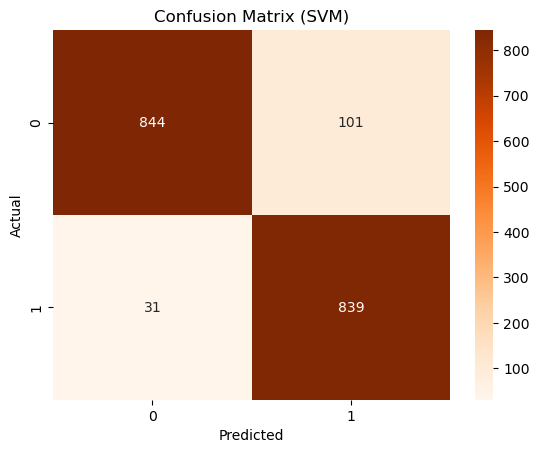

🔎 Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.89      0.93       945
           1       0.89      0.96      0.93       870

    accuracy                           0.93      1815
   macro avg       0.93      0.93      0.93      1815
weighted avg       0.93      0.93      0.93      1815



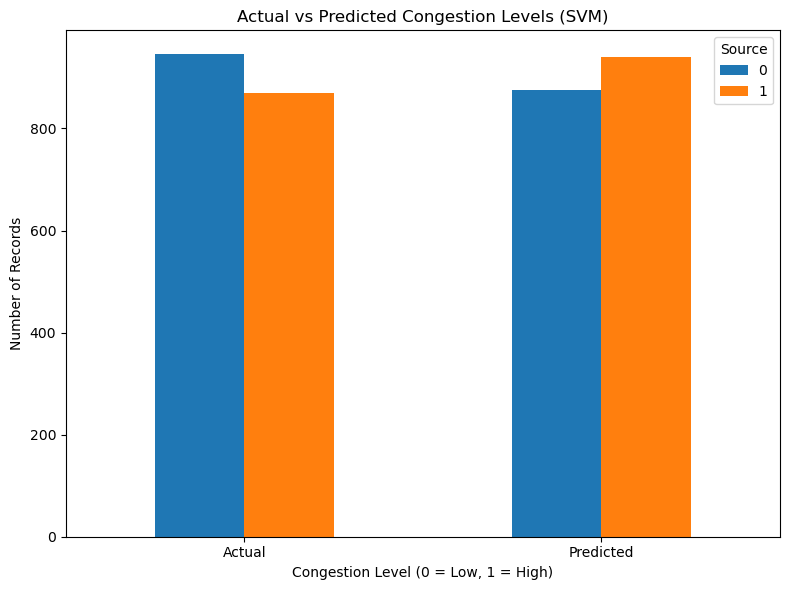

Actual Data:
  - 945 records labeled as Low Congestion (0)
  - 870 records labeled as High Congestion (1)
Predicted Data:
  - 875 predicted as Low Congestion (0)
  - 940 predicted as High Congestion (1)


In [9]:
# Drop missing values
df = df.dropna()

# Create binary target
threshold = df['CRZ_Entries'].median()
df['High_Congestion'] = (df['CRZ_Entries'] >= threshold).astype(int)

# Drop datetime column
df = df.drop(columns=['Toll Week'])

# One-hot encode categorical features
X = pd.get_dummies(df.drop(columns=['CRZ_Entries', 'High_Congestion']), drop_first=True)
y = df['High_Congestion']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM requires feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SVM model
svm_model = SVC(kernel='rbf', random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Predict
y_pred = svm_model.predict(X_test_scaled)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix (SVM)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification report
print("🔎 Classification Report:\n")
print(classification_report(y_test, y_pred))

# Compare actual vs predicted
actual_counts = y_test.value_counts().sort_index()
predicted_counts = pd.Series(y_pred).value_counts().sort_index()
counts = pd.DataFrame({'Actual': actual_counts, 'Predicted': predicted_counts})

counts.T.plot(kind='bar', figsize=(8, 6))
plt.title('Actual vs Predicted Congestion Levels (SVM)')
plt.xlabel('Congestion Level (0 = Low, 1 = High)')
plt.ylabel('Number of Records')
plt.xticks(rotation=0)
plt.legend(title='Source')
plt.tight_layout()
plt.show()

# Print summary
print(f"Actual Data:")
print(f"  - {actual_counts[0]} records labeled as Low Congestion (0)")
print(f"  - {actual_counts[1]} records labeled as High Congestion (1)")
print(f"Predicted Data:")
print(f"  - {predicted_counts[0]} predicted as Low Congestion (0)")
print(f"  - {predicted_counts[1]} predicted as High Congestion (1)")
